In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt



# --- Initial Data Loading and Preparation ---
print("--- Loading and Preparing Data ---")
try:
    fut = pd.read_csv("TRB_USDT/Archive/trb_usdt_futures_export.csv")
    spot = pd.read_csv("TRB_USDT/Archive/trb_usdt_spot_export.csv")
    trades = pd.read_csv("TRB_USDT/Archive/trb_usdt_trades_export.csv")

    for df in [spot, fut, trades]:
        df["time"] = pd.to_datetime(df["time"])
        df.sort_values("time", inplace=True)
        df.reset_index(drop=True, inplace=True)

    # We no longer need mid_price for shock detection, but it's useful for context
    spot["mid_price"] = (spot["bid_price"] + spot["ask_price"]) / 2
    fut["mid_price"] = (fut["bid_price"] + fut["ask_price"]) / 2
    print("Data loaded successfully.")

except FileNotFoundError:
    print("Error: Make sure the CSV files are in the 'TRB_USDT/Archive/' directory.")
    exit()

--- Loading and Preparing Data ---
Data loaded successfully.



# ==============================================================================
### STEP 1: FIND TRUE SHOCK EVENTS
# ==============================================================================

In [2]:
def find_microstructure_shocks(df, shock_threshold=0.0007, window_ms=3):
    """
    Finds shock events based on microstructure insight:
    - Up-shocks are defined by the ASK price moving up.
    - Down-shocks are defined by the BID price moving down.
    """
    print(f"Finding microstructure shocks for dataframe...")
    events = []
    t_ns = df["time"].astype("datetime64[ns]").values.astype(np.int64)
    ask_price = df["ask_price"].to_numpy()
    bid_price = df["bid_price"].to_numpy()
    window_ns = window_ms * 1_000_000

    window_end_indices = np.searchsorted(t_ns, t_ns + window_ns, side="right")

    i = 0
    while i < len(df) - 1:
        baseline_ask = ask_price[i]
        baseline_bid = bid_price[i]

        j_start = i + 1
        j_end = window_end_indices[i]

        found_shock = False
        for k in range(j_start, j_end):
            # Check for up-shock on ASK price
            rel_change_ask = (ask_price[k] - baseline_ask) / baseline_ask
            if rel_change_ask >= shock_threshold:
                shock_dir = 1
                shock_size = rel_change_ask
                found_shock = True
                break

            # Check for down-shock on BID price
            rel_change_bid = (bid_price[k] - baseline_bid) / baseline_bid
            if rel_change_bid <= -shock_threshold:
                shock_dir = -1
                shock_size = abs(rel_change_bid)
                found_shock = True
                break

        if found_shock:
            event_data = df.iloc[k].to_dict()
            event_data["shock_dir"] = shock_dir
            event_data["abs_shock_size"] = shock_size
            events.append(event_data)
            i = k  # Jump ahead to prevent re-detecting the same move
        else:
            i += 1

    return pd.DataFrame(events)



In [3]:
# Generate shock events using the new microstructure logic
spot_shocks_df = find_microstructure_shocks(spot)
print(f"Found {len(spot_shocks_df)} precise spot microstructure shock events.")
fut_shocks_df = find_microstructure_shocks(fut)
print(f"Found {len(fut_shocks_df)} precise futures microstructure shock events.")

Finding microstructure shocks for dataframe...


C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\197467352.py:9: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_ns = df["time"].astype("datetime64[ns]").values.astype(np.int64)


Found 15006 precise spot microstructure shock events.
Finding microstructure shocks for dataframe...


C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\197467352.py:9: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_ns = df["time"].astype("datetime64[ns]").values.astype(np.int64)


Found 21457 precise futures microstructure shock events.



# ==============================================================================
### STEP 2: LABEL FOLLOW EVENTS BY SCANNING 5MS HORIZON
# ==============================================================================


#### TODO function

#### --- 2a: Label if Futures Follow Spot Shocks ---

In [4]:
def label_follow_events_microstructure(
    leader_shocks_df, follower_df, follower_name, reaction_ratio=0.25
):
    """
    Labels if a follower market reacts to a leader's shock.
    - Uses a dynamic reaction threshold (fraction of the leader's shock size).
    - Uses microstructure logic (ask follows ask, bid follows bid).
    """
    print(f"Labeling {follower_name} follow events with dynamic threshold...")

    # Make a copy to avoid SettingWithCopyWarning
    shocks_df = leader_shocks_df.copy()

    # Prepare follower data for quick lookup
    t_ns_follower = follower_df["time"].astype("datetime64[ns]").values.astype(np.int64)
    follower_ask_prices = follower_df["ask_price"].to_numpy()
    follower_bid_prices = follower_df["bid_price"].to_numpy()

    horizon_ns = 5_000_000
    follow_col_name = f"{follower_name}_follow"
    shocks_df[follow_col_name] = 0

    for idx, shock_event in shocks_df.iterrows():
        shock_time_ns = shock_event["time"].value

        # Define the dynamic reaction threshold based on the leader's shock size
        dynamic_reaction_threshold = shock_event["abs_shock_size"] * reaction_ratio

        # Find the 5ms window in the follower data
        j0 = np.searchsorted(t_ns_follower, shock_time_ns, side="left")
        j1 = np.searchsorted(t_ns_follower, shock_time_ns + horizon_ns, side="right")

        if j0 >= j1:
            continue  # No follower ticks in the reaction window

        # Get baseline prices in the follower market (tick right before the shock)
        baseline_idx = max(0, j0 - 1)
        baseline_follower_ask = follower_ask_prices[baseline_idx]
        baseline_follower_bid = follower_bid_prices[baseline_idx]

        # Scan the reaction window using microstructure logic
        if shock_event["shock_dir"] == 1:  # Leader's ASK went up
            # Check if follower's ASK goes up
            reaction_slice_ask = follower_ask_prices[j0:j1]
            max_reaction_ask = np.max(reaction_slice_ask)
            rel_up = (max_reaction_ask - baseline_follower_ask) / baseline_follower_ask
            if rel_up >= dynamic_reaction_threshold:
                shocks_df.loc[idx, follow_col_name] = 1

        elif shock_event["shock_dir"] == -1:  # Leader's BID went down
            # Check if follower's BID goes down
            reaction_slice_bid = follower_bid_prices[j0:j1]
            min_reaction_bid = np.min(reaction_slice_bid)
            rel_down = (
                min_reaction_bid - baseline_follower_bid
            ) / baseline_follower_bid  # will be negative
            if rel_down <= -dynamic_reaction_threshold:
                shocks_df.loc[idx, follow_col_name] = -1

    return shocks_df


# Apply the new labeling logic
spot_shocks_labeled = label_follow_events_microstructure(
    spot_shocks_df, fut, "fut", reaction_ratio=0.25
)
fut_shocks_labeled = label_follow_events_microstructure(
    fut_shocks_df, spot, "spot", reaction_ratio=0.25
)

Labeling fut follow events with dynamic threshold...


C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\116471142.py:15: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_ns_follower = follower_df["time"].astype("datetime64[ns]").values.astype(np.int64)


Labeling spot follow events with dynamic threshold...


C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\116471142.py:15: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_ns_follower = follower_df["time"].astype("datetime64[ns]").values.astype(np.int64)



# ==============================================================================
### STEP 3: FEATURE ENGINEERING AND SAVING
# ==============================================================================

In [5]:
def add_features_to_df(df, trade_df):
    df_out = df.copy()
    window_ns = 10 * 1_000_000
    t_event_ns = df_out["time"].astype("datetime64[ns]").values.astype(np.int64)
    t_trade_ns = trade_df["time"].astype("datetime64[ns]").values.astype(np.int64)
    q_trade = trade_df["quantity"].to_numpy()

    idx_right = np.searchsorted(t_trade_ns, t_event_ns, side="left")
    idx_left = np.searchsorted(t_trade_ns, t_event_ns - window_ns, side="left")
    df_out["past_trade_vol_10ms"] = [
        q_trade[l:r].sum() for l, r in zip(idx_left, idx_right)
    ]
    df_out["spread"] = df_out["ask_price"] - df_out["bid_price"]
    df_out["time_since_prev_shock"] = df_out["time"].diff().dt.total_seconds().fillna(0)
    hour = df_out["time"].dt.hour
    df_out["hour_sin"] = np.sin(2 * np.pi * hour / 24)
    df_out["hour_cos"] = np.cos(2 * np.pi * hour / 24)

    return df_out

In [6]:
# --- Create Feature Set for Model 1: Spot -> Fut ---
model1_df = add_features_to_df(spot_shocks_labeled, trades)
model1_df["target_fut_followed"] = (
    model1_df["shock_dir"] == model1_df["fut_follow"]
).astype(int)
Path("outputs").mkdir(exist_ok=True)
model1_df.to_csv("outputs/model1_spot_led_microstructure.csv", index=False)
print(
    f"\n✅ Saved {len(model1_df)} rows for Model 1 (Spot -> Fut) to 'outputs/model1_spot_led_microstructure.csv'"
)


# --- Create Feature Set for Model 2: Fut -> Spot ---
model2_df = add_features_to_df(fut_shocks_labeled, trades)
model2_df["target_spot_followed"] = (
    model2_df["shock_dir"] == model2_df["spot_follow"]
).astype(int)
model2_df.to_csv("outputs/model2_fut_led_microstructure.csv", index=False)
print(
    f"✅ Saved {len(model2_df)} rows for Model 2 (Fut -> Spot) to 'outputs/model2_fut_led_microstructure.csv'"
)

C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\1787858899.py:4: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_event_ns = df_out["time"].astype("datetime64[ns]").values.astype(np.int64)
C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\1787858899.py:5: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_trade_ns = trade_df["time"].astype("datetime64[ns]").values.astype(np.int64)



✅ Saved 15006 rows for Model 1 (Spot -> Fut) to 'outputs/model1_spot_led_microstructure.csv'


C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\1787858899.py:4: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_event_ns = df_out["time"].astype("datetime64[ns]").values.astype(np.int64)
C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\1787858899.py:5: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_trade_ns = trade_df["time"].astype("datetime64[ns]").values.astype(np.int64)


✅ Saved 21457 rows for Model 2 (Fut -> Spot) to 'outputs/model2_fut_led_microstructure.csv'


==============================================================================
### STEP 4: ANALYSIS AND PLOTTING
==============================================================================


--- Analyzing Enhanced Model Hit-Rates ---


C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\2011323576.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\2011323576.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_xticks()])


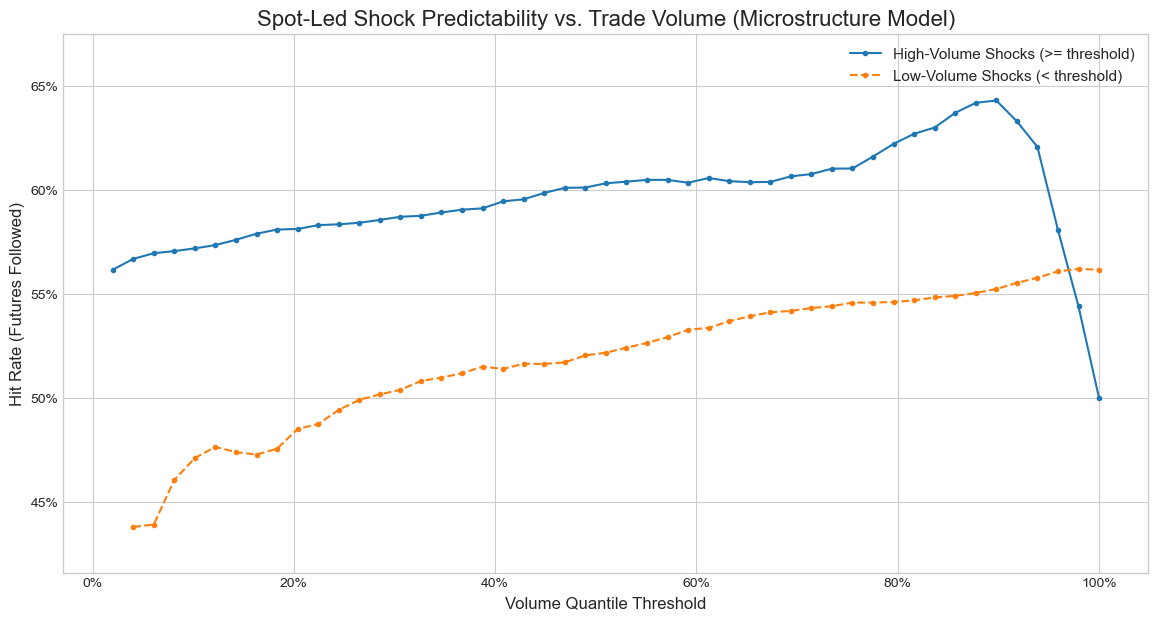

C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\2011323576.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
C:\Users\dogut\AppData\Local\Temp\ipykernel_4784\2011323576.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_xticks()])


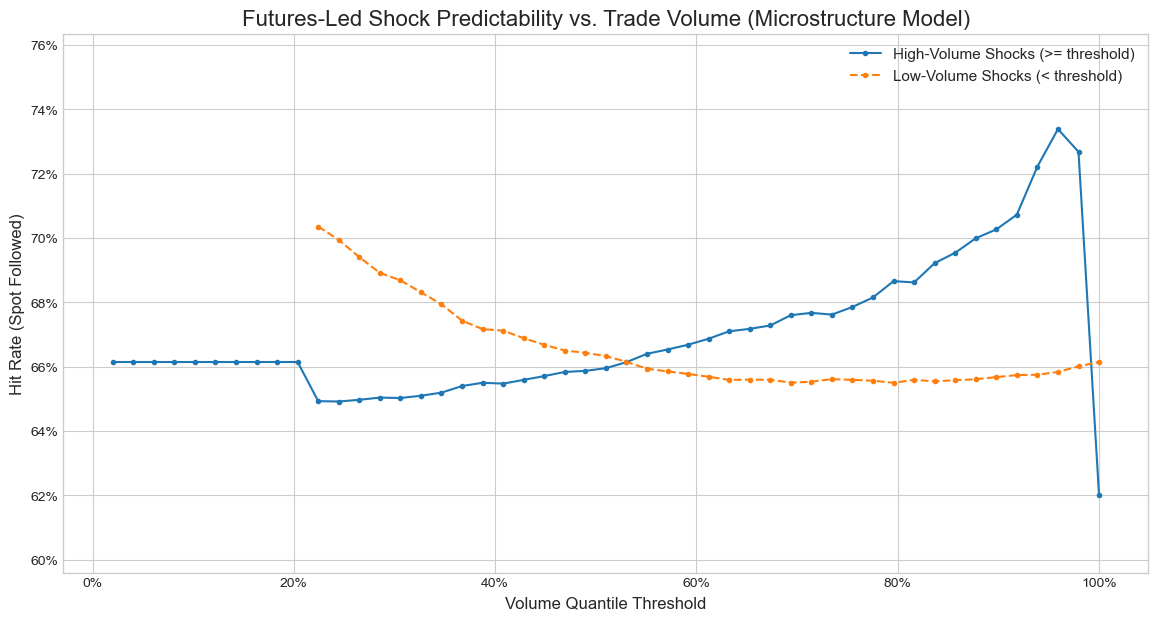


Max hit-rate for Spot-Led, high-volume shocks: 64.30%
Max hit-rate for Futures-Led, high-volume shocks: 74.23%


In [8]:
print("\n--- Analyzing Enhanced Model Hit-Rates ---")


# Helper functions are unchanged
def lead_success_spot(df):
    if len(df) == 0:
        return np.nan
    return df["target_fut_followed"].mean()


def lead_success_fut(df):
    if len(df) == 0:
        return np.nan
    return df["target_spot_followed"].mean()


percentiles = np.linspace(0.02, 1, 49)
spot_high_rate, spot_low_rate = [], []
fut_high_rate, fut_low_rate = [], []
volume_feature = "past_trade_vol_10ms"

# This loop is unchanged
for p in percentiles:
    thr_s = model1_df[volume_feature].quantile(p)
    high_vol_spot_shocks = model1_df[model1_df[volume_feature] >= thr_s]
    low_vol_spot_shocks = model1_df[model1_df[volume_feature] < thr_s]
    spot_high_rate.append(lead_success_spot(high_vol_spot_shocks))
    spot_low_rate.append(lead_success_spot(low_vol_spot_shocks))

    thr_f = model2_df[volume_feature].quantile(p)
    high_vol_fut_shocks = model2_df[model2_df[volume_feature] >= thr_f]
    low_vol_fut_shocks = model2_df[model2_df[volume_feature] < thr_f]
    fut_high_rate.append(lead_success_fut(high_vol_fut_shocks))
    fut_low_rate.append(lead_success_fut(low_vol_fut_shocks))

# --- Plotting the Results (CORRECTED) ---
plt.style.use("seaborn-v0_8-whitegrid")

# --- Plot 1: Spot-Led ---
plt.figure(figsize=(14, 7))
plt.plot(
    percentiles,
    spot_high_rate,
    marker=".",
    linestyle="-",
    label="High-Volume Shocks (>= threshold)",
)
plt.plot(
    percentiles,
    spot_low_rate,
    marker=".",
    linestyle="--",
    label="Low-Volume Shocks (< threshold)",
)
plt.xlabel("Volume Quantile Threshold", fontsize=12)
plt.ylabel("Hit Rate (Futures Followed)", fontsize=12)
plt.title(
    "Spot-Led Shock Predictability vs. Trade Volume (Microstructure Model)", fontsize=16
)
plt.legend(fontsize=11)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_xticks()])

# --- FIX: Use np.nanmin and check for valid data before setting ylim ---
all_spot_rates = spot_high_rate + spot_low_rate
# Create a list of rates that are not NaN
valid_spot_rates = [r for r in all_spot_rates if pd.notna(r)]
if valid_spot_rates:  # Only set limit if there are valid rates
    plt.ylim(bottom=min(valid_spot_rates) * 0.95, top=max(valid_spot_rates) * 1.05)
plt.show()


# --- Plot 2: Futures-Led ---
plt.figure(figsize=(14, 7))
plt.plot(
    percentiles,
    fut_high_rate,
    marker=".",
    linestyle="-",
    label="High-Volume Shocks (>= threshold)",
)
plt.plot(
    percentiles,
    fut_low_rate,
    marker=".",
    linestyle="--",
    label="Low-Volume Shocks (< threshold)",
)
plt.xlabel("Volume Quantile Threshold", fontsize=12)
plt.ylabel("Hit Rate (Spot Followed)", fontsize=12)
plt.title(
    "Futures-Led Shock Predictability vs. Trade Volume (Microstructure Model)",
    fontsize=16,
)
plt.legend(fontsize=11)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_xticks()])

# --- FIX: Use np.nanmin and check for valid data before setting ylim ---
all_fut_rates = fut_high_rate + fut_low_rate
valid_fut_rates = [r for r in all_fut_rates if pd.notna(r)]
if valid_fut_rates:  # Only set limit if there are valid rates
    plt.ylim(bottom=min(valid_fut_rates) * 0.95, top=max(valid_fut_rates) * 1.05)
plt.show()

print(
    f"\nMax hit-rate for Spot-Led, high-volume shocks: {np.nanmax(spot_high_rate):.2%}"
)
print(
    f"Max hit-rate for Futures-Led, high-volume shocks: {np.nanmax(fut_high_rate):.2%}"
)

In [9]:
print("fut_high_rate",max(fut_high_rate))

fut_high_rate 0.74230330672748
